In [1]:
%config Completer.use_jedi = False

In [2]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
from JMetalPy_modified import *
import copy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK20_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK20_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

#UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
#dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)

In [3]:
#save_here_data("../datasets/","UK20_1",distance_matrix_here,time_matrix_here)

In [4]:
def create_initial_solution(nodes,start_positions,end_positions,transit_cost_function,cost_function_parameter_dict:dict):
    result = []
    if(end_positions != None):
        pickup_points = list(set(set(nodes) - set(end_positions)) - set(start_positions))
    else:
        pickup_points = list(set(nodes) - set(start_positions))

    ends = copy.copy(end_positions)
    for start_pos in start_positions:
        result.append(start_pos)
        node_amount = int(len(pickup_points)/len(start_positions))
        
        closest_positions = sorted(pickup_points, key = lambda node: transit_cost_function(start_pos,node,**cost_function_parameter_dict))[:node_amount]
    
        for taken_position in closest_positions:
            pickup_points.remove(taken_position)
            result.append(taken_position)
        
        if len(ends) > 1:
            closest_end = sorted(ends, key = lambda node: transit_cost_function(result[-1],node,**cost_function_parameter_dict))[0]
        elif len(ends) == 1:
            closest_end = ends[0]
        
        result.append(closest_end)
        ends.remove(closest_end)
        
        
        
    for node in pickup_points:
        if node not in result:
            result.insert(1,node)

    return result

def shuffle_paths(variables,starts,ends):
    #random.seed(1)
    result = []
    start_indices = []
    end_indices = []
    for start,end in zip(starts,ends):
        end_indices.append(variables.index(end))
        start_indices.append(variables.index(start))
    end_indices.sort()
    start_indices.sort()
    
    for start, end in zip(start_indices,end_indices):
        result.append(variables[start])
        result.extend(random.sample(variables[start+1:end],k=len(variables[start+1:end])))
        result.append(variables[end])

    return result
            


In [11]:
import math
import random
from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution
from itertools import chain
import collections
from bisect import bisect_left


class VRP(PermutationProblem):
    
    def __init__(self,problemData):
        check_type(problemData,dict)
        fuel_eq_types = {0:'linear',1:'wong'}
        super(VRP,self).__init__()
        
        self.distance_matrix = problemData['distance_matrix']
        self.time_matrix = problemData['time_matrix']
        self.demands = problemData['demands']
        self.max_no_of_vehicle = problemData['vehicle_amount']
        self.vehicle_capacities = problemData['vehicle_capacities']
        self.object_directions=[self.MINIMIZE,self.MAXIMIZE]
        self.number_of_objectives = problemData['objective_amount']
        self.objective_functions=problemData['objective_functions']
        self.objective_labels = problemData['objective_labels']
        self.number_of_constraints = problemData['constraint_amount']
        self.constraint_functions= problemData['constraint_functions']
        self.start_positions = problemData['start_points']
        self.end_positions = problemData['end_points']
        self.number_of_variables = problemData['number_of_cities']
        self.depot = 0
        self.cost_history = []
        self.fuel_eq_type = fuel_eq_types[problemData['fuelEq']]
        self.name = 'VRP'
        self.assignClosestEndPoint = False
        
        
        
    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        
        def split_paths(values,starts):
            result = []
            for start_index,start in enumerate(starts):
                index = values.index(start)
                if start_index == len(starts)-1:
                    result.append(values[index:])
                else:
                    next_index = values.index(starts[start_index+1])
                    result.append(values[index:next_index])
            return result
        
        fitness = 0
        
        permutation = list(map(int, solution.variables))
        
        #print(permutation)
        start_positions = self.start_positions
        paths = list([[x] for x in start_positions])
        vehicles = 1
        current_load = 0
        vehicle_index=0
        ends = []

#         #======================Construct paths==========================#
        for node_index in permutation:
            
            if not node_index in start_positions:
                if vehicle_index == len(paths):
                    solution=self.create_solution()
                    return
                
                if node_index in self.end_positions:
                    if not self.assignClosestEndPoint:
                        paths[vehicle_index].append(node_index)
                    vehicle_index+=1
                    current_load = 0
                else:
          
                    load = current_load + demand_callback(node_index,self.demands,self.start_positions)
                    paths[vehicle_index].append(node_index)
        
        if self.assignClosestEndPoint:
            minNodes = 1
        else:
            minNodes = 2   
        solution.path=list(filter(lambda path: len(path)> minNodes,paths))
        
        # put filter here removing paths only consisting of start & end nodes 
        
        #================================================================#
        if self.assignClosestEndPoint and (self.end_positions != None):
            for index,path in enumerate(solution.path):
                solution.path[index].append(int(self.distance_matrix.iloc[self.end_positions,path[-1],].sort_values().index[0]))
            
        
        #======================CALCULATE FITNESS=========================#
        vehicle_empty_weight = 3000
        solution.vehicle_loads = []
        solution.vehicle_fuel_consumptions = []
        solution.vehicle_route_distances = []
        solution.vehicle_route_times = []
        
        
        dist = 0
        for vehicle_route in paths:
            vehicle_load = 0
            vehicle_fuel_consumption = 0
            vehicle_route_distance = 0
            vehicle_route_time = 0
            total_vehicle_weight = vehicle_empty_weight
            
            for node_index in range(len(vehicle_route)-1):
                from_node = vehicle_route[node_index]
                to_node = vehicle_route[node_index + 1]
                
                if self.fuel_eq_type == 'linear':
                
                    vehicle_fuel_consumption += fuel_consumption_linear(from_node=from_node,to_node=to_node,
                                                                        distance_matrix=self.distance_matrix,demands=self.demands,
                                                                        cumulative_route_load=vehicle_load,meta_data=meta_data)
                
                elif self.fuel_eq_type == 'wong':
                    
                    vehicle_fuel_consumption += fuel_consumption_wong(from_node=from_node,to_node=to_node,
                                                                     distance_matrix=self.distance_matrix,time_matrix= self.time_matrix,
                                                                     demands=self.demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                     start_positions=self.start_positions,meta_data=meta_data)

                vehicle_load += demand_callback(from_node,self.demands,self.start_positions)
                vehicle_route_distance += self.distance_matrix.iloc[from_node][to_node]
                vehicle_route_time += self.time_matrix.iloc[from_node][to_node]
                

            #Increment fitness value
            fitness += vehicle_fuel_consumption
            dist += vehicle_route_distance
            solution.vehicle_route_distances.append(round(vehicle_route_distance,2))
            solution.vehicle_fuel_consumptions.append(vehicle_fuel_consumption)
            solution.vehicle_route_times.append(vehicle_route_time)
            solution.vehicle_loads.append(vehicle_load)
        #=================================================================#
        
        
        
        #fitness += max(solution.vehicle_fuel_consumptions)*2 #+ max(solution.vehicle_route_times)
        solution.constraints = [0 for x in range(len(solution.constraints))]
        solution.flag = []
        #============CHECK CONSTRAINTS==============
        #All nodes must be visited
        if self.assignClosestEndPoint:
            allNodes = list(set(copy.copy(permutation))-set(self.end_positions))
        else:
            allNodes = copy.copy(permutation)
            
        if not self.__allVisited(allNodes,paths,ends):
            solution.constraints[0] = -100
            solution.flag.append("visited")
        
        if self.__overLoaded(solution.path):
            solution.constraints[1] = 3650 - max(solution.vehicle_loads)
            solution.flag.append("overload")
        
        if not self.__correctStart(solution.path):
            solution.constraints[2] = -100
            solution.flag.append("start")
        
        if max(solution.vehicle_route_times) > (7*60*60):
            solution.constraints[3] = (7*60*60) - max(solution.vehicle_route_times)
            solution.flag.append("time")

        # If end nodes are set, all paths must end at the one of the end nodes
        if self.end_positions != None:
            final_path_positions = [path[-1]  for path in solution.path]
            faultyEndpoints = self.__checkEndPoints(final_path_positions)
            if  faultyEndpoints > 0:
                solution.constraints[4] = -faultyEndpoints  
                solution.flag.append("end")
                
        if self.name in ["SA","GA"]:
            for constraint_val in solution.constraints:
                fitness += abs(constraint_val)
        
        # If cumulative drive time > 8 hours, add 10e10 to fitness
        #===========================================
        
        
        if len(solution.objectives)==2:
            solution.objectives[0] = fitness
            solution.objectives[1] = len(solution.path)#sum(solution.vehicle_route_times)#max(solution.vehicle_loads)
            
        if len(solution.objectives) == 1:
            solution.objectives[0] = fitness#
        
        # Update objective fitness
        if fitness < 10e10:
            self.cost_history.append(fitness)
        return solution
    
    def __correctStart(self,paths):
        firstcheck = paths[0][0] in self.start_positions 
        
        secondcheck = True
        for path in paths:
            if len(set(path).intersection(set(self.start_positions))) > 1:
                secondcheck = False
        return firstcheck * secondcheck
        
        
        
    def __overLoaded(self,paths):
        for path, capacity in zip(paths,self.vehicle_capacities):
            load = 0
            for i in range(len(path)):
                load += demand_callback(from_node=path[i],demands=self.demands,start_nodes=self.start_positions)
            if load > capacity:
                return True
        
            
            
    def __checkEndPoints(self,ends):
        errorCount = 0 
        for end in ends:
            if end not in self.end_positions:
                errorCount +=1
        return errorCount
        #return set(ends).issubset(set(self.end_positions))
    
    def __containsNoEndPoints(self,paths):
        return set(self.end_positions).isdisjoint(set(chain.from_iterable(paths)))
    
    def __allVisited(self,variables,paths,ends):
        points = list(set(variables) - set(ends))
        return set(points).issubset(set(chain.from_iterable(paths)))
    
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        routes = []
        for index in range(len(solution.path) - 1):
            if solution.path[index] == 0 :
                routes.append([0])
            else:
                routes[-1].append(solution.path[index])
                

        return routes
    
    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives,number_of_constraints=self.number_of_constraints)

        
        self.start_positions = random.sample(self.start_positions,k=len(self.start_positions))
        
        
        cost_function_dict = {"distance_matrix":self.distance_matrix,"time_matrix":self.time_matrix,
                              "demands":self.demands,"vehicle_weight":3000,"start_positions":self.start_positions,"meta_data":meta_data}
        
        nodes = {}
        if self.end_positions != None:
            node_amount = list(range(self.number_of_variables))


        points = create_initial_solution(node_amount,self.start_positions,self.end_positions, fuel_consumption_wong,cost_function_dict)
        
        #Should try to not shuffle the cheapest paths
        
        new_solution.variables = shuffle_paths(points,self.start_positions,self.end_positions)
 

        
        return new_solution
        
    def get_name(self):
        return self.name

In [12]:
def saveParameterData(path,name,data):
    DF = pd.DataFrame(data)
    DF.to_csv("{}{}.csv".format(path,name),index=False)

In [15]:
starts =[0,6,10,15]#,20,35,40]
vehicle_amount = len(starts)
ends = [4,2,20,5]#,32,45,1]
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0

station_data["Demand(kg)"][starts] = 0
station_data["Demand(kg)"][ends]= 0
customer_demands = customer_demands.tolist()

vehicle_capacities = [meta_data['Max Load(kg)'].astype(int)[0] for x in range(vehicle_amount)]


distance_matrix = distance_matrix_here

data_model_input_single_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':1,'objective_labels':['Total Fuel'],'constraint_amount':5,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1}



data_model_input_multi_objective = {'distance_matrix':distance_matrix,'time_matrix':time_matrix_here,'vehicle_amount':vehicle_amount,
                   'demands':customer_demands,'vehicle_capacities':vehicle_capacities,
                    'objective_amount':2,'objective_labels':['Total Fuel','Max Fuel'],'constraint_amount':5,
                    'objective_functions':[],'constraint_functions':[],
                    'number_of_cities':distance_matrix.shape[0],
                    'start_points':starts,'end_points':ends,'fuelEq':1}

amount_of_runs = 30
amount_of_evaluations = 5000

mutation_arange = np.arange(0.2,0.9,0.15)
crossover_arange = np.arange(0.2,0.9,0.15)



# define the name of the directory to be created
logPath = "../logs/{}-{}-{}-{}-{}/".format(datetime.today().year,datetime.today().month,datetime.today().day,datetime.today().hour,datetime.today().minute)
if not os.path.exists(logPath):
    try:
        os.mkdir(logPath)
    except OSError:
        print ("Creation of the directory %s failed" % logPath)
    else:
        print ("Successfully created the directory %s " % logPath)

Successfully created the directory ../logs/2021-2-17-15-37/ 


In [16]:
from jmetal.core.observer import Observer
from IPython.display import clear_output
import logging
LOGGER = logging.getLogger('jmetal')
class PerformanceObserver(Observer):
    def __init__(self, max_iter:int,frequency: float = 1.0) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.performances = []
        self.max_iter = max_iter
        self.currentBestFitness = [10e10]
        self.total_consumptions = []
        self.currentEpoch = 0
        self.maxEpochs = 0
        self.maxDriveTimes = []
        self.bestFitnessTime=0
        self.violations = []
        
    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']
        if type(solutions) == list:
            solution = solutions[0]
        else:
            solution = solutions
        
        if hasattr(solution, 'vehicle_fuel_consumptions'):

            if (evaluations % self.display_frequency) == 0 and solution:
                fitness = solution.objectives
                consumption = sum(solution.vehicle_fuel_consumptions)
                flags=solution.flag
                if len(fitness) == 1:
                    self.performances.append(fitness[0])
                else:
                    self.performances.append(fitness)
                    
                self.maxDriveTimes.append(max(solution.vehicle_route_times))
                self.total_consumptions.append(consumption)
                self.computing_time = computing_time
                current_route = solution.path
                if fitness[0] < self.currentBestFitness[0]:
                    self.currentBestFitness = fitness#[0]
                    self.bestFitnessTime = computing_time
                self.violations.append(overall_constraint_violation_degree(solution))
                clear_output(wait=True)
                if len(fitness) == 1:
                    print('Epoch:{} of {}\nEvaluations: {}/{} \nBest fitness: {}\nBest total fuel consumption:{} \nComputing time: {}s\nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}\nViolation:{}'.format(
                            self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter, round(fitness[0],4),round(consumption,2), round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                        ,overall_constraint_violation_degree(solution)),flush=True)
                    
                elif len(fitness)== 2:
                    print('Epoch:{} of {}\nEvaluations: {}/{} \nBest fitness: {} --- {}\nBest total fuel consumption:{} \nComputing time: {}s\nAverage computing speed: {}it/s\nCurrent Route:{}\nFlags: {}\nViolation:{}'.format(
                        self.currentEpoch+1,self.maxEpochs,evaluations,self.max_iter, round(self.currentBestFitness[0],4),round(self.currentBestFitness[1],4),round(consumption,2), round(computing_time,2),round(evaluations/computing_time,2),current_route,flags
                    ,overall_constraint_violation_degree(solution)),flush=True)


In [17]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_SA = []#[{"mutation":0.8},{"mutation":0.5}]
for x in mutation_arange:
    parameter_list_SA.append({"mutation":np.round(x,2)})#,"alpha":y})
parameter_data_SA = []
computation_times_SA = []
results_SA = []

for index,param in enumerate(parameter_list_SA):
    plot_data_SA = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
    for x in range(amount_of_runs):
        problem_SA = VRP(data_model_input_single_objective)
        problem_SA.name = "SA"
        problem_SA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                       mutation=PermutationSwapMutation(param["mutation"]),
                                       termination_criterion=StoppingByEvaluations(max_evaluations))
        #algorithm_SA.alpha=param["alpha"]
        performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=20)
        performance_observer_SA.maxEpochs= len(parameter_list_SA) * amount_of_runs
        performance_observer_SA.currentEpoch = (index*amount_of_runs) + x

        algorithm_SA.observable.register(observer=performance_observer_SA)
        algorithm_SA.run() 
        
        solutions_SA = algorithm_SA.get_result()
        
        
        plot_data_SA['fitness'].append(performance_observer_SA.performances)
        plot_data_SA['fuel_consumption'].append(performance_observer_SA.total_consumptions)
        plot_data_SA['optimal_time'].append(performance_observer_SA.bestFitnessTime)
        plot_data_SA['maxDriveTimes'].append(performance_observer_SA.maxDriveTimes)
        plot_data_SA['violation'].append(performance_observer_SA.violations)
        plot_data_SA['paths'].append(solutions_SA.path)
    param["paramGroup"] = index
    param["algorithm"] = problem_SA.name

    parameter_data_SA.append({"parameters":param,"results":plot_data_SA})
    
    solutions_SA = algorithm_SA.get_result()
    print("Feasible solution found: {}".format(is_feasible(solutions_SA)))
    results_SA.append(get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_SA.append(performance_observer_SA.computing_time)
final_results_SA = generate_final_results(results_SA, computation_times_SA)
final_results_SA

saveParameterData(logPath,"SA_20",parameter_data_SA)

Epoch:150 of 150
Evaluations: 5000/5000 
Best fitness: 103.5298
Best total fuel consumption:103.53 
Computing time: 55.8s
Average computing speed: 89.61it/s
Current Route:[[0, 8, 3, 1, 17, 9, 4], [6, 11, 16, 12, 14, 5], [15, 18, 13, 19, 7, 5]]
Flags: []
Violation:0
Feasible solution found: True


In [ ]:
get_results(solutions_SA.path,problem_SA.distance_matrix,station_data,meta_data,time_matrix_here)

In [18]:
from jmetal.algorithm.singleobjective import LocalSearch
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime
parameter_list_LS =[]
for x in mutation_arange:
    parameter_list_LS.append({"mutation":np.round(x,2)})
parameter_data_LS = []
computation_times_LS = []
results_LS = []

for index,param in enumerate(parameter_list_LS):
        plot_data_LS = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
        for x in range(amount_of_runs):
            problem_LS = VRP(data_model_input_single_objective)
            problem_LS.name = "LS"
            problem_LS.assignClosestEndPoint = True
            max_evaluations = amount_of_evaluations

            algorithm_LS = LocalSearch(problem=problem_LS,
                                           mutation=PermutationSwapMutation(param["mutation"]),
                                           termination_criterion=StoppingByEvaluations(max_evaluations),
                                          comparator=DominanceComparator())

            performance_observer_LS = PerformanceObserver(max_iter=max_evaluations,frequency=20)
            performance_observer_LS.maxEpochs= len(parameter_list_LS) * amount_of_runs
            performance_observer_LS.currentEpoch = (index*amount_of_runs) + x

            algorithm_LS.observable.register(observer=performance_observer_LS)
            algorithm_LS.run()
            
            
            solutions_LS = algorithm_LS.get_result()
            
            plot_data_LS['fitness'].append(performance_observer_LS.performances)
            plot_data_LS['fuel_consumption'].append(performance_observer_LS.total_consumptions)
            plot_data_LS['optimal_time'].append(performance_observer_LS.bestFitnessTime)
            plot_data_LS['maxDriveTimes'].append(performance_observer_LS.maxDriveTimes)
            plot_data_LS['violation'].append(performance_observer_LS.violations)
            plot_data_LS['paths'].append(solutions_LS.path)
       
        param["paramGroup"] = index
        param["algorithm"] = problem_LS.name
            
    
        parameter_data_LS.append({"parameters":param,"results":plot_data_LS})
        
        solutions_LS = algorithm_LS.get_result()
        print("Feasible solution found: {}".format(is_feasible(solutions_LS)))
        results_LS.append(get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here))
        computation_times_LS.append(performance_observer_LS.computing_time)
final_results_LS = generate_final_results(results_LS, computation_times_LS)
final_results_LS


saveParameterData(logPath,"LS_20",parameter_data_LS)

Epoch:150 of 150
Evaluations: 5000/5000 
Best fitness: 90.7299
Best total fuel consumption:90.73 
Computing time: 56.86s
Average computing speed: 87.93it/s
Current Route:[[15, 13, 19, 7, 5], [0, 8, 16, 14, 12, 11, 2], [6, 1, 9, 17, 3, 18, 20]]
Flags: []
Violation:0
Feasible solution found: True


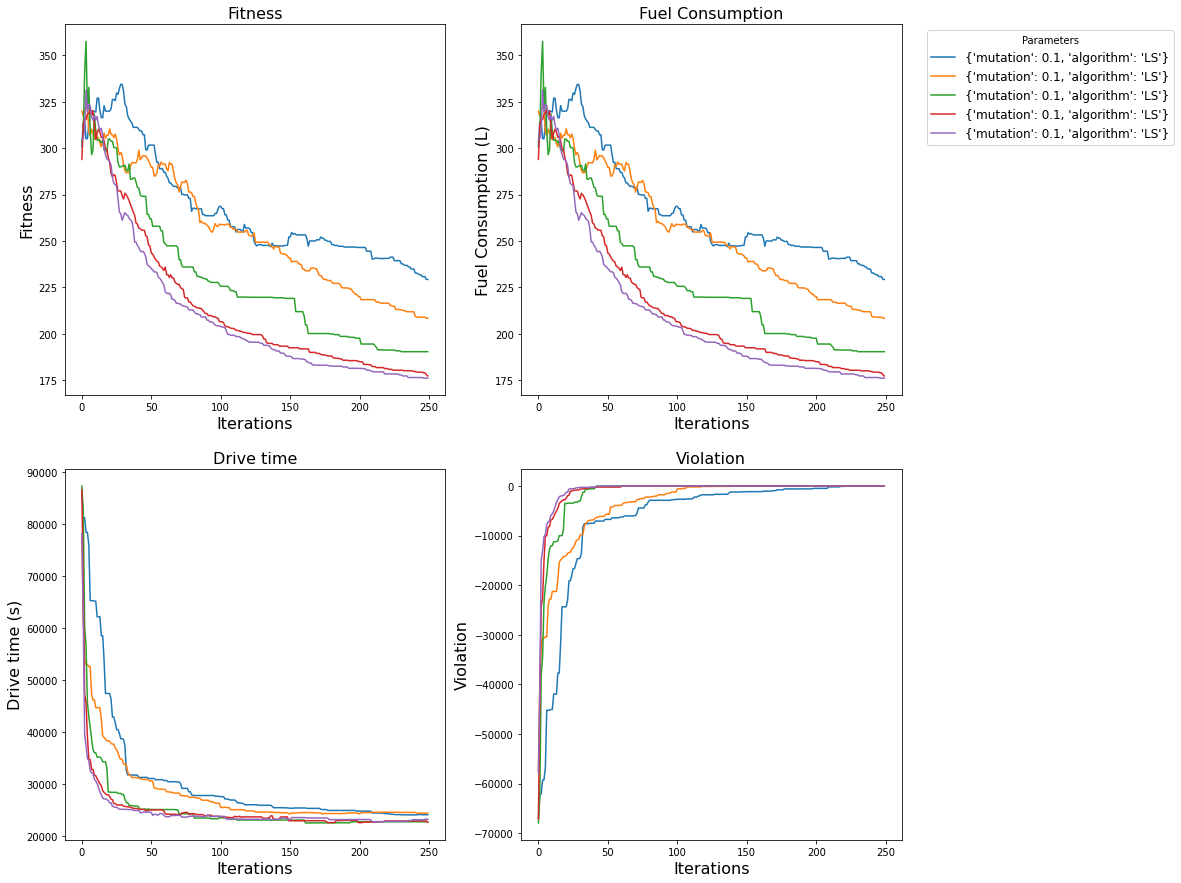

In [12]:
plotModelParameterComparison(parameter_data_LS,
                             ["fitness","fuel_consumption","maxDriveTimes","violation"],
                             ["Fitness","Fuel Consumption","Drive time","Violation"],
                             ["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],5)

In [235]:
get_results(solutions_LS.path,problem_LS.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,422.304,1498,54.513586,12.908612,38.403841,9.093885,60.916552,24957,06:55:57.00
1,248.410,2535,34.086671,13.721940,23.191149,9.335836,56.596165,15801,04:23:21.00


In [68]:
np.arange(0.2,0.9,0.15)

array([0.2 , 0.35, 0.5 , 0.65, 0.8 ])

In [82]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.core.quality_indicator import InvertedGenerationalDistance,HyperVolume
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from datetime import datetime

parameter_list_NSGAIII = []#[{"mutation":0.8,"crossover":0.5}]#,{"mutation":0.5,"crossover":0.5},{'mutation':0.1,'crossover':0.5}]
for x in mutation_arange:
    for y in crossover_arange:
        parameter_list_NSGAIII.append({"mutation":round(x,2),"crossover":round(y,2)})
parameter_data_NSGAIII = []
computation_times_NSGAIII = []
results_NSGAIII = []

for index,param in enumerate(parameter_list_NSGAIII):
    plot_data_NSGAIII = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
    for x in range(amount_of_runs):
        problem_NSGAIII = VRP(data_model_input_single_objective)
        problem_NSGAIII.name = "NSGA-III"
        problem_NSGAIII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_NSGAIII = NSGAIII(problem=problem_NSGAIII,
                                population_size=20,
                                reference_directions=UniformReferenceDirectionFactory(1, n_points=20),
                                mutation= PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),
                                selection=BestSolutionSelection()
                                   )

        performance_observer_NSGAIII = PerformanceObserver(max_iter=max_evaluations,frequency=1)

        performance_observer_NSGAIII.maxEpochs= len(parameter_list_NSGAIII) * amount_of_runs
        performance_observer_NSGAIII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAIII.observable.register(observer=performance_observer_NSGAIII)
        algorithm_NSGAIII.run()

        solutions_NSGAIII = algorithm_NSGAIII.get_result()
        front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)

        plot_data_NSGAIII['fitness'].append(performance_observer_NSGAIII.performances)
        plot_data_NSGAIII['fuel_consumption'].append(performance_observer_NSGAIII.total_consumptions)
        plot_data_NSGAIII['optimal_time'].append(performance_observer_NSGAIII.bestFitnessTime)
        plot_data_NSGAIII['maxDriveTimes'].append(performance_observer_NSGAIII.maxDriveTimes)
        plot_data_NSGAIII['violation'].append(performance_observer_NSGAIII.violations)
        plot_data_NSGAIII['paths'].append(front_NSGAIII[0].path)

    
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAIII.name
    
    parameter_data_NSGAIII.append({"parameters":param,"results":plot_data_NSGAIII})
    
    solutions_NSGAIII = algorithm_NSGAIII.get_result()
    front_NSGAIII = get_non_dominated_solutions(solutions_NSGAIII)
    print("Feasible solution found: {}".format(is_feasible(front_NSGAIII[0])))
    results_NSGAIII.append(get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAIII.append(performance_observer_NSGAIII.computing_time)
final_results_NSGAIII = generate_final_results(results_NSGAIII,computation_times_NSGAIII)    
final_results_NSGAIII

saveParameterData(logPath,"NSGAIII_20",parameter_data_NSGAIII)

Epoch:2 of 5
Evaluations: 5000/5000 
Best fitness: 92.3781
Best total fuel consumption:92.38 
Computing time: 16.03s
Average computing speed: 311.97it/s
Current Route:[[15, 19, 7, 16, 14, 12, 11, 2], [0, 8, 3, 18, 13, 5], [6, 1, 17, 9, 4]]
Flags: []
Violation:0
Feasible solution found: True


Process ForkPoolWorker-1412:
Process ForkPoolWorker-1409:
Process ForkPoolWorker-1407:
Process ForkPoolWorker-1415:
Process ForkPoolWorker-1408:
Process ForkPoolWorker-1406:
Process ForkPoolWorker-1416:
Process ForkPoolWorker-1405:
Process ForkPoolWorker-1413:
Process ForkPoolWorker-1410:
Process ForkPoolWorker-1411:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
 

In [23]:
pd.DataFrame(parameter_data_NSGAIII)

,parameters,results
0,"{'mutation': 0.3, 'crossover': 0.3, 'paramGrou...","{'fitness': [[287.36554056048175, 272.26808624..."
1,"{'mutation': 0.3, 'crossover': 0.4, 'paramGrou...","{'fitness': [[275.48913972041714, 265.80545172..."
2,"{'mutation': 0.3, 'crossover': 0.5, 'paramGrou...","{'fitness': [[238.02522792706816, 256.28512962..."
3,"{'mutation': 0.3, 'crossover': 0.6, 'paramGrou...","{'fitness': [[277.73216923856955, 272.02755981..."
4,"{'mutation': 0.4, 'crossover': 0.3, 'paramGrou...","{'fitness': [[270.56064463475883, 308.96284266..."
5,"{'mutation': 0.4, 'crossover': 0.4, 'paramGrou...","{'fitness': [[266.17198872386916, 309.14719767..."
6,"{'mutation': 0.4, 'crossover': 0.5, 'paramGrou...","{'fitness': [[304.7074887674963, 309.535339942..."
7,"{'mutation': 0.4, 'crossover': 0.6, 'paramGrou...","{'fitness': [[274.9538103202183, 277.812785592..."
8,"{'mutation': 0.5, 'crossover': 0.3, 'paramGrou...","{'fitness': [[274.6817059022485, 262.986661085..."
9,"{'mutation': 0.5, 'crossover': 0.4, 'paramGrou...","{'fitness': [[273.5057325444518, 293.841827392..."


In [140]:
get_results(front_NSGAIII[0].path,problem_NSGAIII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Wong et al.),Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,190.333,3401,25.385264,13.337290,20.298297,10.664623,47.307291,14484,04:01:24.00
1,222.524,2706,29.854860,13.416467,23.593846,10.602832,46.313604,17297,04:48:17.00
2,100.830,1082,12.897210,12.791044,10.344159,10.259009,35.815294,10135,02:48:55.00
3,186.744,1245,23.626719,12.651929,20.158927,10.794953,56.130784,11977,03:19:37.00
4,85.035,1159,10.985764,12.919109,9.036296,10.626561,48.140588,6359,01:45:59.00
5,334.321,3033,46.217712,13.824352,36.230139,10.836932,48.178840,24981,06:56:21.00
6,352.902,3519,46.206540,13.093306,38.770572,10.986215,53.630259,23689,06:34:49.00


In [57]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAII, UniformReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameter_list_NSGAII = []#[{"mutation":0.6,"crossover":0.8}]#,{"mutation":0.5,"crossover":0.5}]
for x in mutation_arange:
    for y in crossover_arange:
        parameter_list_NSGAII.append({"mutation":np.round(x,2),"crossover":round(y,2)})
parameter_data_NSGAII = []
computation_times_NSGAII = []
results_NSGAII = []
for index,param in enumerate(parameter_list_NSGAII):
    plot_data_NSGAII = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
    for x in range(amount_of_runs):
        problem_NSGAII = VRP(data_model_input_single_objective)
        problem_NSGAII.name = "NSGA-II"
        problem_NSGAII.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_NSGAII = NSGAII(problem=problem_NSGAII,
                                population_size=20,
                                offspring_population_size=20,
                                mutation=PermutationSwapMutation(param["mutation"]),
                                crossover=PMXCrossover(param["crossover"]),
                                termination_criterion=StoppingByEvaluations(max_evaluations),
                                population_evaluator=MultiprocessEvaluator(),selection=BestSolutionSelection()
                                   )

        performance_observer_NSGAII = PerformanceObserver(max_iter=max_evaluations,frequency=1)
        performance_observer_NSGAII.maxEpochs= len(parameter_list_NSGAII) * amount_of_runs
        performance_observer_NSGAII.currentEpoch = (index*amount_of_runs) + x
        algorithm_NSGAII.observable.register(observer=performance_observer_NSGAII)
        algorithm_NSGAII.run()
        
        solutions_NSGAII = algorithm_NSGAII.get_result()
        front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
        
        plot_data_NSGAII['fitness'].append(performance_observer_NSGAII.performances)
        plot_data_NSGAII['fuel_consumption'].append(performance_observer_NSGAII.total_consumptions)
        plot_data_NSGAII['optimal_time'].append(performance_observer_NSGAII.bestFitnessTime)
        plot_data_NSGAII['maxDriveTimes'].append(performance_observer_NSGAII.maxDriveTimes)
        plot_data_NSGAII['violation'].append(performance_observer_NSGAII.violations)
        plot_data_NSGAII['paths'].append(front_NSGAII[0].path)
    param["paramGroup"] = index
    param["algorithm"] = problem_NSGAII.name
        
    parameter_data_NSGAII.append({"parameters":param,"results":plot_data_NSGAII})
    
    solutions_NSGAII = algorithm_NSGAII.get_result()
    front_NSGAII = get_non_dominated_solutions(solutions_NSGAII)
    results_NSGAII.append(get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_NSGAII.append(performance_observer_NSGAII.computing_time)
final_results_NSGAII = generate_final_results(results_NSGAII,computation_times_NSGAII)    
final_results_NSGAII

saveParameterData(logPath,"NSGAII_20",parameter_data_NSGAII)

Epoch:5 of 5
Evaluations: 5000/5000 
Best fitness: 158.7641
Best total fuel consumption:158.76 
Computing time: 39.87s
Average computing speed: 125.41it/s
Current Route:[[15, 47, 9, 23, 34, 19, 30], [40, 13, 14, 29, 24, 46, 31, 2], [20, 33, 50, 26, 37, 2], [0, 42, 28, 12, 5, 32], [10, 11, 22, 43, 39, 18, 49, 3, 32], [35, 21, 41, 7, 8, 27, 38, 16, 30], [6, 48, 44, 17, 36, 45]]
Flags: []
Violation:0


,Max,Min,Mean,Std
Total distance (km),1476.967000,1476.967000,1476.967000,NaN
Total load (kg),17474,17474,17474.000000,NaN
Total Estimated Fuel Consumption (L) (Hao et al.),194.593697,194.593697,194.593697,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),13.195368,13.195368,13.195368,NaN
Total Estimated Fuel Consumption (L) (Wong et al.),158.764142,158.764142,158.764142,NaN
Avg Estimated Fuel Conspumtion (L/100km) (Wong et al.),10.718842,10.718842,10.718842,NaN
Avg Speed (km/h),47.780491,47.780491,47.780491,NaN
Computaion Time,39.867984,39.867984,39.867984,NaN


Process ForkPoolWorker-118:
Process ForkPoolWorker-113:
Process ForkPoolWorker-109:
Process ForkPoolWorker-117:
Process ForkPoolWorker-119:
Process ForkPoolWorker-111:
Process ForkPoolWorker-115:
Process ForkPoolWorker-114:
Process ForkPoolWorker-116:
Process ForkPoolWorker-110:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-112:
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-120:
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.

In [53]:
get_results(front_NSGAII[0].path,problem_NSGAII.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,156.953,1209,20.533152,13.082357,13.868537,8.836108,45.607458,12389,03:26:29.00
1,261.634,3647,36.149308,13.816747,23.271987,8.894863,49.729799,18940,05:15:40.00
2,246.456,1363,31.729428,12.874277,23.086169,9.367258,63.054623,14071,03:54:31.00
3,339.244,2938,46.399018,13.677182,30.462398,8.979495,50.239763,24309,06:45:09.00
4,374.514,1937,48.184354,12.865835,34.450113,9.198618,62.858427,21449,05:57:29.00
5,325.269,2985,44.429682,13.659366,29.134865,8.957160,50.503252,23186,06:26:26.00
6,245.203,3395,33.055009,13.480671,22.414056,9.141020,56.121228,15729,04:22:09.00


In [20]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.selection import Selection
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime
from JMetalPy_modified import GeneticAlgorithm2

parameter_list_GA =[]#][{"mutation":0.8,"crossover":0.5},{"mutation":0.5,"crossover":0.5}]
for x in mutation_arange:
    for y in crossover_arange:
        parameter_list_GA.append({"mutation":np.round(x,2),"crossover":round(y,2)})
parameter_data_GA = []
computation_times_GA = []
results_GA = []
for index,param in enumerate(parameter_list_GA):
    plot_data_GA = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
    for x in range(amount_of_runs):
        problem_GA = VRP(data_model_input_single_objective)
        problem_GA.name = "GA"
        problem_GA.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations

        algorithm_GA = GeneticAlgorithm(problem=problem_GA,
                        population_size=20,
                        offspring_population_size=20,
                        mutation=PermutationSwapMutation(param["mutation"]),
                        crossover=PMXCrossover(param["crossover"]),
                        selection=BestSolutionSelection(),
                        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
                        ,population_evaluator=MultiprocessEvaluator()
                        )


        performance_observer_GA = PerformanceObserver(max_iter=max_evaluations,frequency=1)
        performance_observer_GA.maxEpochs= len(parameter_list_GA) * amount_of_runs
        performance_observer_GA.currentEpoch = (index*amount_of_runs) + x
        algorithm_GA.observable.register(observer=performance_observer_GA)
        start_time = datetime.now() 
        algorithm_GA.run()
        run_time = datetime.now() - start_time
        solutions_GA = algorithm_GA.get_result()
        print("Feasible solution found: {}".format(is_feasible(solutions_GA)))

        plot_data_GA['fitness'].append(performance_observer_GA.performances)
        plot_data_GA['fuel_consumption'].append(performance_observer_GA.total_consumptions)
        plot_data_GA['optimal_time'].append(performance_observer_GA.bestFitnessTime)
        plot_data_GA['maxDriveTimes'].append(performance_observer_GA.maxDriveTimes)
        plot_data_GA['violation'].append(performance_observer_GA.violations)
        plot_data_GA['paths'].append(solutions_GA.path)
        
    param["paramGroup"] = index
    param["algorithm"] = problem_GA.name
        
    parameter_data_GA.append({"parameters":param,"results":plot_data_GA})
    
    results_GA.append(get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_GA.append(performance_observer_GA.computing_time)
final_results_GA = generate_final_results(results_GA,computation_times_GA)   
final_results_GA

saveParameterData(logPath,"GA_20",parameter_data_GA)

Epoch:750 of 750
Evaluations: 5000/5000 
Best fitness: 152.1028
Best total fuel consumption:152.1 
Computing time: 12.38s
Average computing speed: 403.76it/s
Current Route:[[6, 1, 3, 18, 13, 19, 7, 5], [15, 17, 9, 4], [10, 12, 14, 5], [0, 8, 16, 11, 2]]
Flags: []
Violation:0
Feasible solution found: True


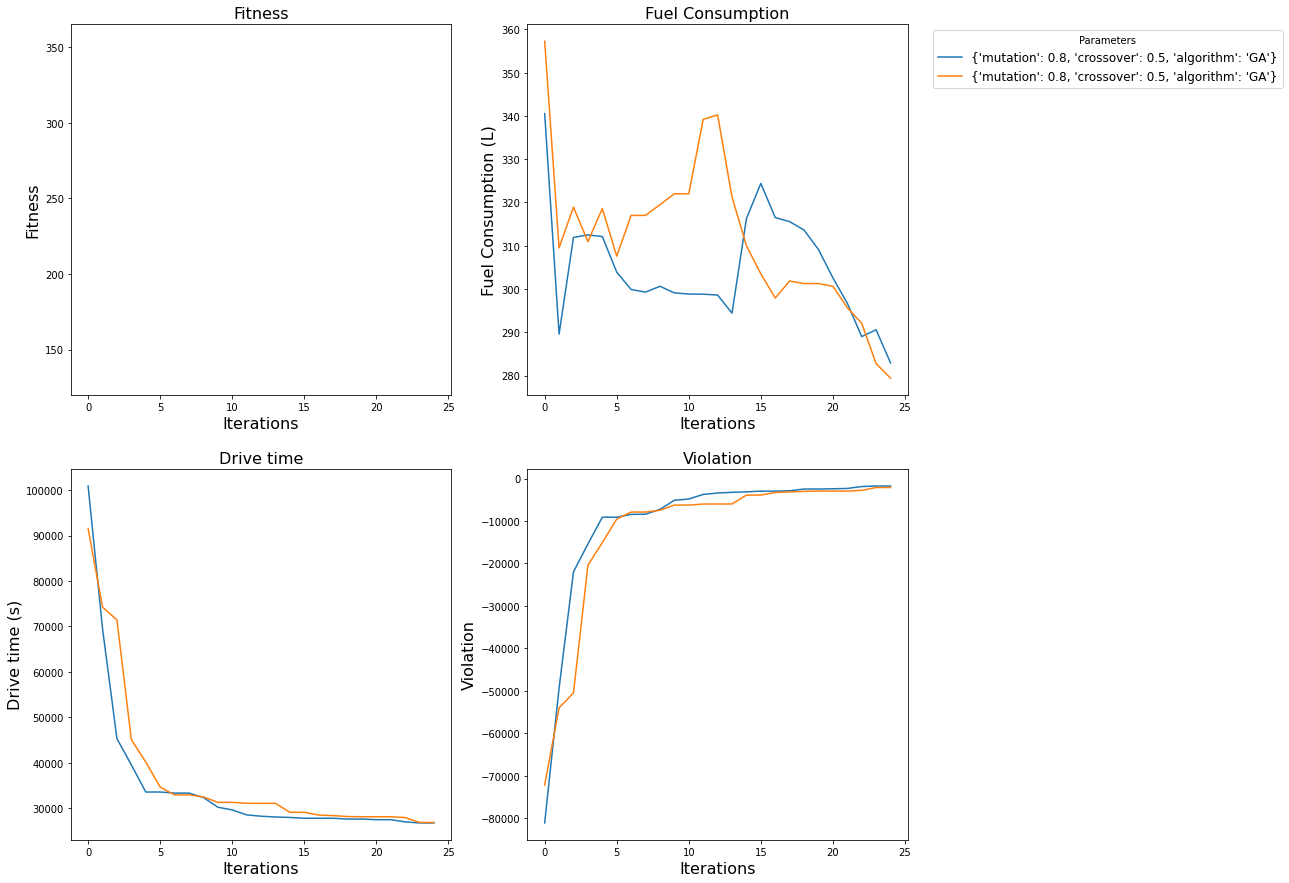

In [19]:
plotModelParameterComparison(parameter_data_GA,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],5)


In [30]:
get_results(solutions_GA.path,problem_GA.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,297.392,5156,40.503641,13.619614,26.248083,8.826089,46.716900,22917,06:21:57.00
1,232.541,3346,31.956685,13.742387,20.581724,8.850794,46.864894,17863,04:57:43.00
2,191.540,3187,26.134408,13.644360,16.668033,8.702116,42.743863,16132,04:28:52.00
3,419.714,2748,54.407871,12.963082,38.184609,9.097769,53.188201,28408,07:53:28.00
4,123.767,2278,16.170009,13.064879,10.869597,8.782307,45.872665,9713,02:41:53.00
5,127.329,759,16.296964,12.799099,11.005692,8.643508,43.481730,10542,02:55:42.00


In [19]:
from jmetal.algorithm.singleobjective import GeneticAlgorithm
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.selection import Selection
from jmetal.algorithm.multiobjective.hype import HYPE
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver, VisualizerObserver,PrintObjectivesObserver,BasicObserver
from jmetal.util.evaluator import MultiprocessEvaluator
from datetime import datetime

parameter_list_HYPE =[]#[{"mutation":0.8,"crossover":0.5},{"mutation":0.5,"crossover":0.5}]
for x in mutation_arange:
    for y in crossover_arange:
        parameter_list_HYPE.append({"mutation":np.round(x,2),"crossover":round(y,2)})

computation_times_HYPE = []
results_HYPE = []
parameter_data_HYPE = []
for index,param in enumerate(parameter_list_HYPE):
    plot_data_HYPE = {'fitness':[],'fuel_consumption':[],'optimal_time':[],'maxDriveTimes':[],'violation':[],'paths':[]}
    
    for x in range(amount_of_runs):

        problem_HYPE = VRP(data_model_input_single_objective)
        problem_HYPE.name = "HYPE"
        problem_HYPE.assignClosestEndPoint = True
        max_evaluations = amount_of_evaluations
        reference_point = PermutationSolution(number_of_variables=problem_HYPE.number_of_variables,
                                              number_of_objectives=problem_HYPE.number_of_objectives,
                                              number_of_constraints=problem_HYPE.number_of_constraints)


        algorithm_HYPE = HYPE(
            problem=problem_HYPE,
            reference_point=reference_point,
            population_size=20,
            offspring_population_size=20,
            mutation=PermutationSwapMutation(param["mutation"]),
            crossover=PMXCrossover(param["crossover"]),
            termination_criterion=StoppingByEvaluations(max_evaluations),
            population_evaluator=MultiprocessEvaluator()
        )


        performance_observer_HYPE = PerformanceObserver(max_iter=max_evaluations,frequency=1)
        performance_observer_HYPE.maxEpochs= len(parameter_list_HYPE)
        performance_observer_HYPE.currentEpoch = (index*amount_of_runs) + x
        algorithm_HYPE.observable.register(observer=performance_observer_HYPE)

        algorithm_HYPE.run()

        solutions_HYPE = algorithm_HYPE.get_result()
        front_HYPE = get_non_dominated_solutions(solutions_HYPE)

        plot_data_HYPE['fitness'].append(performance_observer_HYPE.performances)
        plot_data_HYPE['fuel_consumption'].append(performance_observer_HYPE.total_consumptions)
        plot_data_HYPE['optimal_time'].append(performance_observer_HYPE.bestFitnessTime)
        plot_data_HYPE['maxDriveTimes'].append(performance_observer_HYPE.maxDriveTimes)
        plot_data_HYPE['violation'].append(performance_observer_HYPE.violations)
        plot_data_HYPE['paths'].append(front_HYPE[0].path)
        
    param["paramGroup"] = index
    param["algorithm"] = problem_HYPE.name
    parameter_data_HYPE.append({"parameters":param,"results":plot_data_HYPE})
    
    front_HYPE = get_non_dominated_solutions(solutions_HYPE)
    print("Feasible solution found: {}".format(is_feasible(solutions_HYPE[0])))
    results_HYPE.append(get_results(front_HYPE[0].path,problem_HYPE.distance_matrix,station_data,meta_data,time_matrix_here))
    computation_times_HYPE.append(performance_observer_HYPE.computing_time)
final_results_HYPE = generate_final_results(results_HYPE,computation_times_HYPE)   
final_results_HYPE

saveParameterData(logPath,"HYPE_20",parameter_data_HYPE)

Epoch:750 of 25
Evaluations: 5000/5000 
Best fitness: 100.1525
Best total fuel consumption:100.15 
Computing time: 12.12s
Average computing speed: 412.6it/s
Current Route:[[6, 3, 18, 20], [15, 16, 11, 12, 14, 7, 19, 13, 5], [0, 8, 1, 17, 9, 4]]
Flags: []
Violation:0
Feasible solution found: True


In [116]:
get_results(front_HYPE[0].path,problem_HYPE.distance_matrix,station_data,meta_data,time_matrix_here)

,Total distance (km),Total load (kg),Total Estimated Fuel Consumption (L) (Hao et al.),Avg Estimated Fuel Conspumtion (L/100km) (Hao et al.),Total Estimated Fuel Consumption (L) (Rakha et al.),Avg Estimated Fuel Conspumtion (L/100km) (Rakha et al.),Avg Speed (km/h),Total Travel Time (s),Travel Time hh:mm:ss
0,288.481,3453,38.048167,13.189141,27.055267,9.378527,62.396756,16644,04:37:24.00
1,223.850,3149,29.880131,13.348283,19.901674,8.890629,49.433198,16302,04:31:42.00
2,339.555,2271,45.091801,13.279675,31.196238,9.187389,60.637829,20159,05:35:59.00
3,283.412,2549,36.887303,13.015434,24.773863,8.741289,46.501217,21941,06:05:41.00
4,375.401,1332,48.238442,12.849844,34.577928,9.210931,59.490408,22717,06:18:37.00
5,368.785,2771,49.260342,13.357469,34.241893,9.285056,57.979998,22898,06:21:38.00
6,234.822,1949,30.225109,12.871498,21.982776,9.361464,66.261107,12758,03:32:38.00


In [17]:
from IPython.display import display, HTML
from numpy import nan
from matplotlib.font_manager import FontProperties
def plotModelParameterComparison(parameterData, resultFieldsToPlot,plotTitles,yAxisLabels,amountToPlot=1):

    fig,axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15))
    #paramResults = parameterData[:amountToPlot]
    paramResults = pd.DataFrame(parameterData)
    for i,paramResult in paramResults.iterrows():#[:10]:
        for name, ax, title, ylabel in zip(resultFieldsToPlot,axs.flatten(),plotTitles,yAxisLabels):
            #print(paramResult['results'][name])
            ax.plot(eval(paramResult['results'])[name],label = paramResult['parameters'])
            ax.set_title(title,fontsize=16)
            ax.set_ylabel(ylabel,fontsize=16)
            ax.set_xlabel("Iterations",fontsize=16)
            ax.set_xticklabels(np.arange(0,5000,800))
            if paramResult['parameters']['algorithm'] in ["SA","GA"] and name == "fitness":
                ax.set_ylim(120,365)

    fontP = FontProperties()
    fontP.set_size('xx-small')
    plt.legend( title='Parameters', bbox_to_anchor=(1.05, 2.2), loc='upper left',fontsize=12)  

In [19]:
from numpy import nan
names = ["SA","LS"]#,"NSGAIII","NSGAII","GA","HYPE"]
dataPath = "../logs/2021-02-16/"

def read_parameter_data(path,names):
    
    data = []
    for name in names:
        inputData = pd.read_csv("{}{}.csv".format(path,name),dtype=object)
        inputData.infer_objects()#convert_dtypes(convert_string=False)
   
        data.append(inputData)
    return data
  
    
    
    
def make_best_plot(names,data,solutionAmount=1):
    returnData = []
    for name, algoData in zip(names,data):
        
        #algoData.results= literal_eval(algoData.results.app
        algoData.infer_objects()
        algoResults = []
        #algoResults
        for result in algoData.results:
            result = eval(result)
            fitness = np.array(result['fitness'])
            #print(fitness)
            algoResults.append(fitness[-1])
            #algoResults.append([x[-1] for x in fitness][0])
            
        argSortedResults = np.argsort(algoResults)
        
        
        tempDatas = algoData.iloc[argSortedResults[:solutionAmount]]
        #print(type(tempDatas.iloc[0]['results']))
        for index in range(len(tempDatas)):
            
            params = eval(tempDatas.iloc[index]["parameters"])
            dictValue = eval(tempDatas.iloc[index]['results'])
            #print(dictValue['fitness'])
            params["algorithm"]=name
            params["value"] = round(dictValue['fitness'][-1],2)
            tempDatas.iloc[index]["parameters"]=params
            returnData.append(tempDatas.iloc[index])
    
    return returnData



In [20]:
names = ["NSGAIII"]#,"NSGAII","GA","HYPE"]
dataPath = "../logs/2021-02-17/"
algorithm_data = make_best_plot(names,read_parameter_data(dataPath,names),2)
plotModelParameterComparison(algorithm_data,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],2)


IndexError: positional indexers are out-of-bounds

<ipython-input-17-8f93f2855316>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



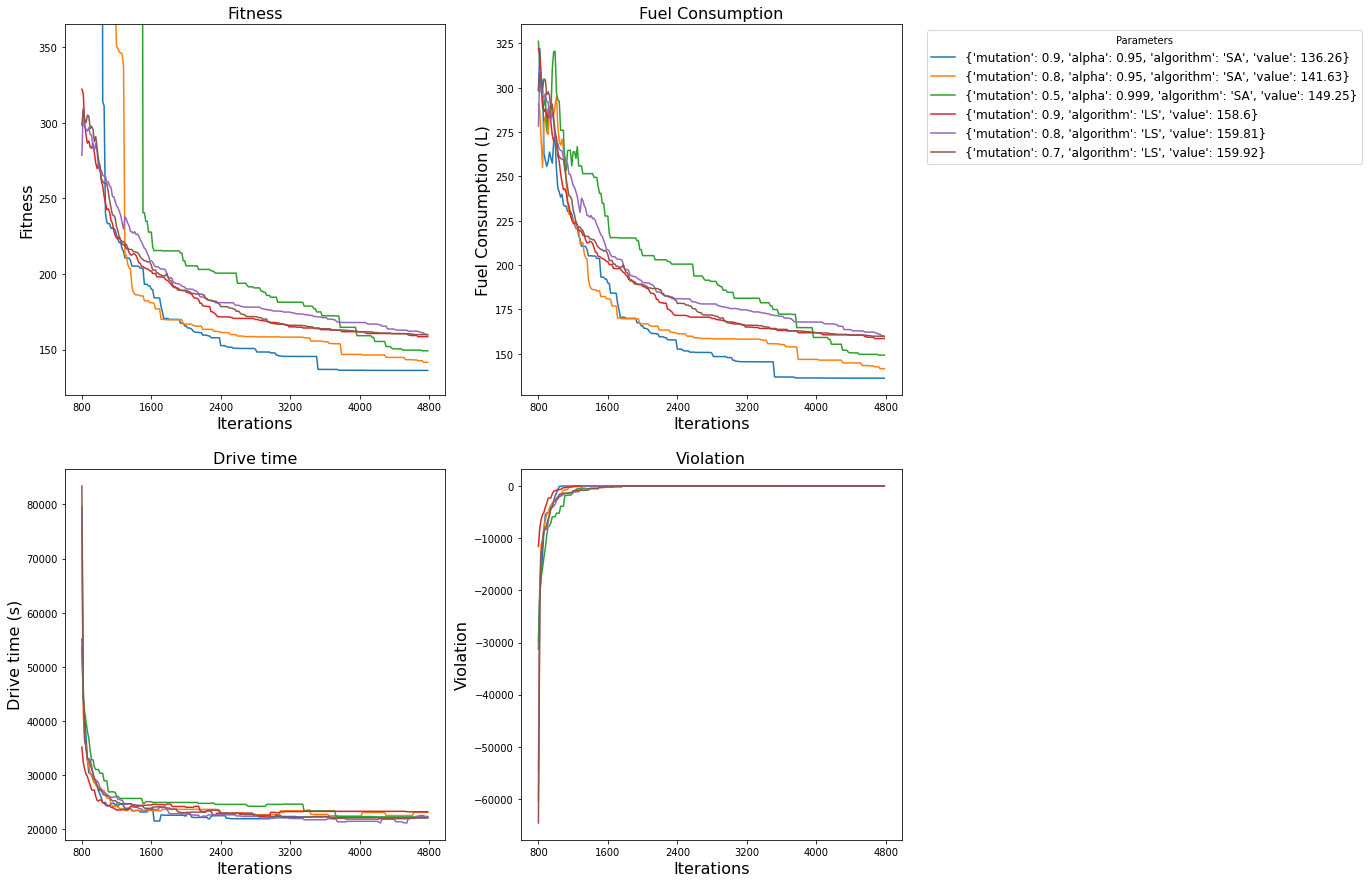

In [26]:
names = ["SA","LS"]
dataPath = "../logs/2021-02-16/"
algorithm_data = make_best_plot(names,read_parameter_data(dataPath,names),3)
plotModelParameterComparison(algorithm_data,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"],2)


In [61]:
pd.DataFrame(algorithm_data[0])

,28
parameters,"{'mutation': 0.6, 'crossover': 0.8, 'algorithm..."
results,"{'fitness': [295.7292725873498, 275.8072391227..."


<ipython-input-24-8f93f2855316>:16: UserWarning:

FixedFormatter should only be used together with FixedLocator



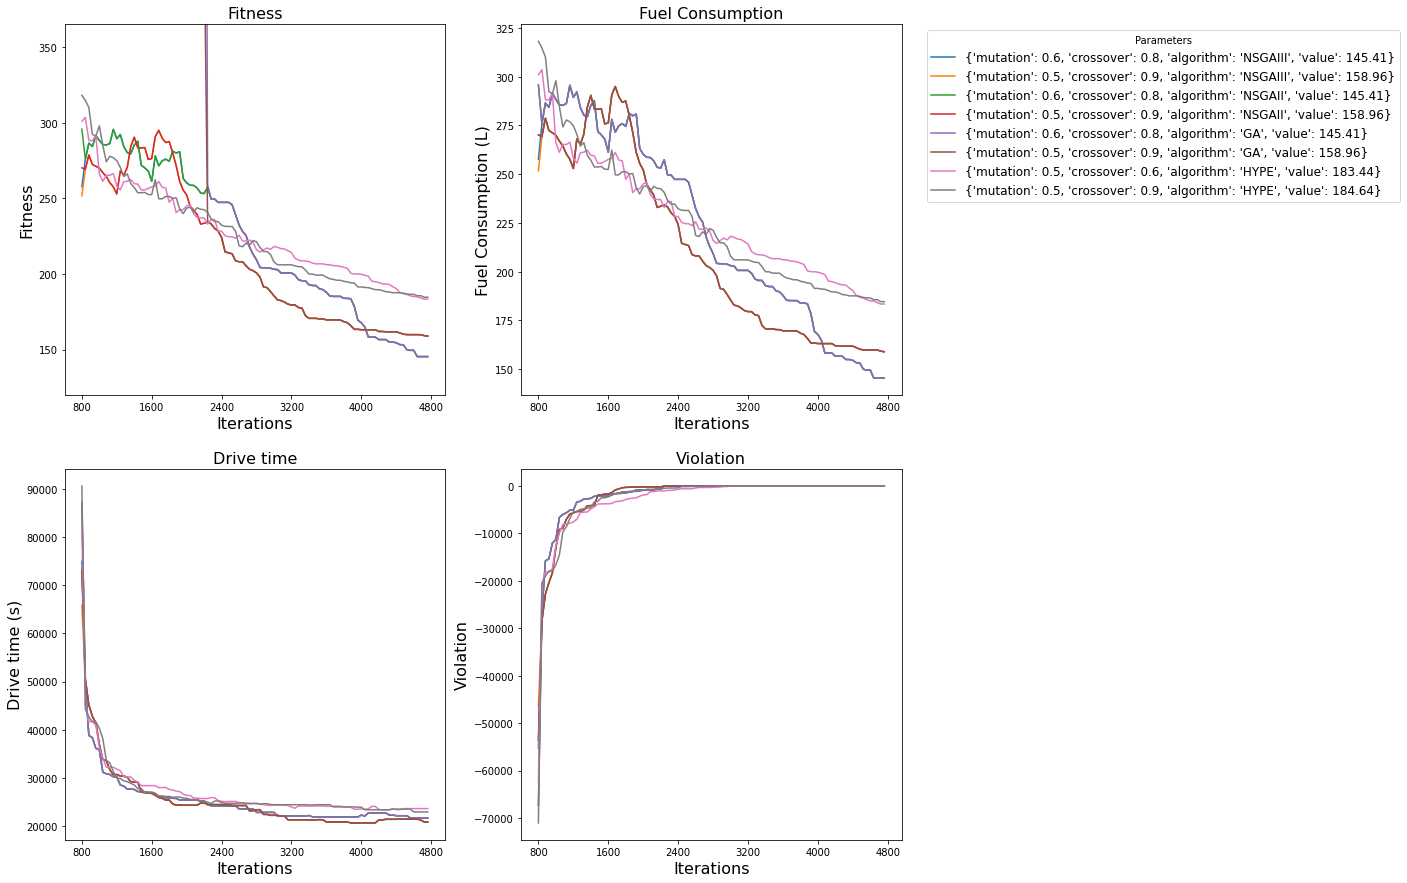

In [28]:
names = ["NSGAIII","NSGAII","GA","HYPE"]
dataPath = "../logs/2021-02-16/"
algorithm_data = make_best_plot(names,read_parameter_data(dataPath,names),2)
plotModelParameterComparison(algorithm_data,["fitness","fuel_consumption","maxDriveTimes","violation"],["Fitness","Fuel Consumption","Drive time","Violation"],["Fitness","Fuel Consumption (L)","Drive time (s)","Violation"])


In [39]:
for x in algorithm_data:
    print(x['parameters'])
    #print(eval(x['results'])['fitness'][-1])

{'mutation': 0.6, 'crossover': 0.8, 'algorithm': 'NSGAIII', 'value': 145.41}
{'mutation': 0.5, 'crossover': 0.9, 'algorithm': 'NSGAIII', 'value': 158.96}
{'mutation': 0.6, 'crossover': 0.8, 'algorithm': 'NSGAII', 'value': 145.41}
{'mutation': 0.5, 'crossover': 0.9, 'algorithm': 'NSGAII', 'value': 158.96}
{'mutation': 0.6, 'crossover': 0.8, 'algorithm': 'GA', 'value': 145.41}
{'mutation': 0.5, 'crossover': 0.9, 'algorithm': 'GA', 'value': 158.96}
{'mutation': 0.5, 'crossover': 0.6, 'algorithm': 'HYPE', 'value': 183.44}
{'mutation': 0.5, 'crossover': 0.9, 'algorithm': 'HYPE', 'value': 184.64}


In [41]:
algorithm_data[0]['parameters']

{'mutation': 0.6, 'crossover': 0.8, 'algorithm': 'NSGAIII', 'value': 145.41}

In [26]:
algorithm_data[0]['results']

"{'fitness': [30016.967859148735, 20249.253306215163, 17319.862982796367, 13413.821811276215, 8701.756695749376, 5692.058152489192, 5437.09039585095, 5390.626235928314, 4718.978392669369, 3909.3457210426814, 3899.0776981158406, 3085.4040885132667, 2169.6779569287655, 1624.1939243890843, 912.9744077881908, 313.9677978469929, 311.1749760889992, 239.9608651365082, 234.08718856683976, 233.22775665134867, 233.22775665134867, 230.27835562026044, 230.27835562026044, 230.26242173077026, 228.8958912288005, 225.555325669177, 222.72565574901532, 220.723074975591, 220.58226580339314, 216.54850057142713, 214.8772091591653, 210.63738714820184, 210.63738714820184, 210.63738714820184, 210.51657525027895, 208.88821324563006, 205.2532646311432, 205.2532646311432, 205.2532646311432, 205.15574285642396, 205.15574285642396, 205.0941093336954, 203.81938954562827, 203.81938954562827, 203.6081109787031, 193.25170065281958, 193.25170065281958, 193.18756109749148, 192.13046346825425, 192.13046346825425, 189.919

In [117]:
algoritm_observers = [performance_observer_SA,performance_observer_LS,performance_observer_GA,performance_observer_NSGAII,performance_observer_NSGAIII]
types =["JMetalPy-SA","LS","GA","NSGAII","NSGAIII"]
metrics = ["Fitness","Fuel Consumption","Computation Time"]#,"DeltaTime"]
columns = []
data = []

for algoType in types:
    for metric in metrics:
        columns.append("{}-{}".format(algoType,metric))

for observer in  algoritm_observers:
    for index in range(len(observer.performances)):
        data.append([observer.performances[index],observer.total_consumptions[index],observer.computing_times[index]])

    
np_data = np.array(data)
np_data= np_data.reshape((250,15))

df_data = pd.DataFrame(np_data,columns=columns)

df_data
df_data.to_csv("../logs/2021-02-09/11_54_JMetalPy_50_1.csv",index=False)

NameError: name 'performance_observer_SA' is not defined

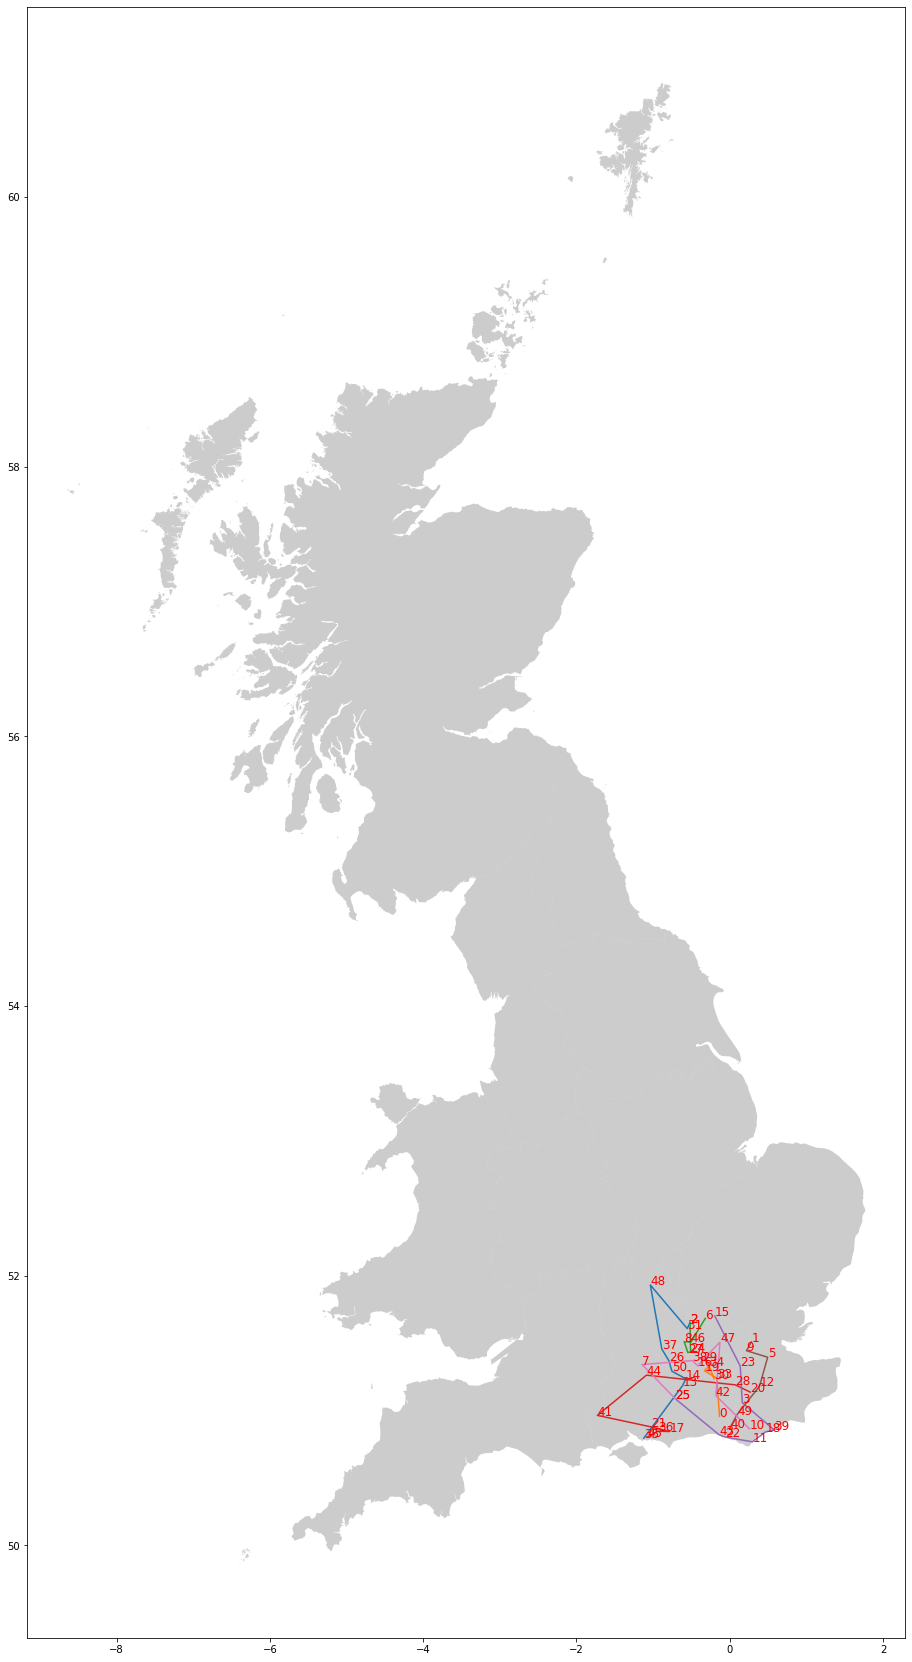

In [37]:
plot_routes(front_NSGAIII[0].path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

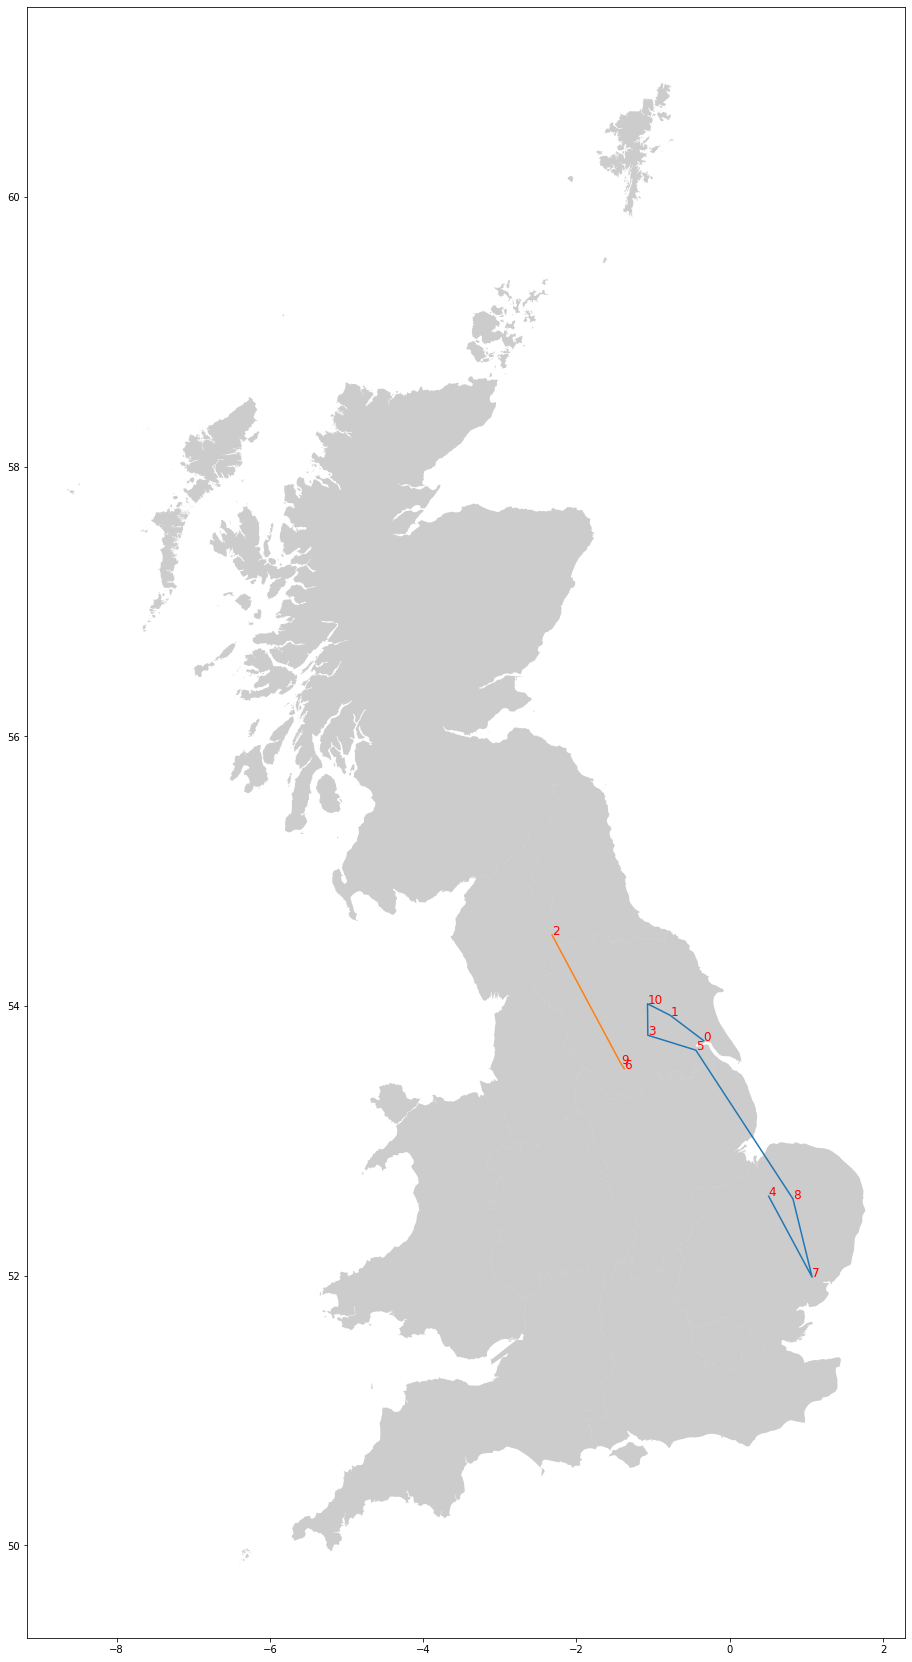

In [55]:
plot_routes(solutions_GA.path,points_coordinate,dbf,station_ids = True, here_api=False, api_key=api)

In [38]:
vehicle_routes = []
vehicle_stops = []
vehicle_stop_demands = []
for v_route in solutions_NSGAIII[0].path:
    vehicle_stop_demands.append(np.array(customer_demands)[v_route[1:]])
    vehicle_stops.append(points_coordinate[v_route[1:]])
    vehicle_routes.append(decode_routes(generate_routes(points_coordinate[v_route],api)))

100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


In [39]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

In [40]:
import folium
from folium.plugins import PolyLineTextPath
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

centerpoint = [np.mean(points_coordinate[:,0]),np.mean(points_coordinate[:,1])]

folium_map = folium.Map(location=centerpoint, tiles='openstreetmap', zoom_start=8)

# Create popups for the pickup-points
position_popups = []
for solution_path,stop_demands in zip(solutions_NSGAIII[0].path,vehicle_stop_demands):
    position_popups.append(["Node: {}\nDemand: {}(kg)".format(node_id,node_demand) for node_id,node_demand in zip(solution_path[1:],stop_demands)])


markerCluster = MarkerCluster().add_to(folium_map)
# Add pickup-points and start positions to map
for startPos,stop_demands,stop_pos in zip(starts,position_popups,vehicle_stops):
    folium.Marker(location=list(points_coordinate[startPos]),popup="Startpos\nNode: {}".format(startPos),icon=folium.Icon(color='red', icon_color='white', icon='truck', angle=0, prefix='fa')).add_to(markerCluster)
    if len(stop_pos)>1:

        MarkerCluster(stop_pos[:-1],popups=stop_demands[:-1]).add_to(folium_map)
        folium.Marker(location=list(stop_pos[-1]),popup="End\n{}".format(stop_demands[-1]),
                      icon=folium.Icon(color='green', icon_color='white', icon='flag-checkered', angle=0, prefix='fa')).add_to(markerCluster)
        
    else:
        folium.Marker(location=list(stop_pos[0]),popup="{}".format(stop_demands[0]),
                      icon=folium.Icon(color='red', icon_color='white', icon='exclamation-circle', angle=0, prefix='fa')).add_to(markerCluster)
        

colormap = folium.branca.colormap.LinearColormap(colors=['red','green', 'blue'],index=[0,int(len(vehicle_routes)/2),len(vehicle_routes)])
# Add routes to map with popups
for index,(route,route_load,route_fuel_consumption, route_distance) in enumerate(zip(vehicle_routes,solutions_NSGAIII[0].vehicle_loads,
                                                                                     solutions_NSGAIII[0].vehicle_fuel_consumptions,solutions_NSGAIII[0].vehicle_route_distances)):
    
    if(len(route) > 1):
        line = folium.PolyLine(route,color=colormap(index),
                               popup="Route Load: {}(kg)\nFuel consumption: {}(L)\nDistance: {}(km)".format(route_load,route_fuel_consumption,round(route_distance/1000,2))).add_to(folium_map)
        PolyLineTextPath(line, "\u27A4    ",repeat=True).add_to(folium_map)        

# Display the map
folium_map